# Usean mallin luokittelua akkujärjestelmille

Tämä versio on kehitetty tehtävän 4 aikana tehdystä luokittelusta. Tällä kertaa tavoitteena ei ole löytää lisää järjestelmiä, joissa voisi olla koneoppimisen perusteella akku, vaan tavoitteena on saada mallit luokittelemaan järjestelmät mahdollisimman tarkasti niille annetusta datasta.

Kaikkia tämän tutkimuksen aikana tehtyjä löydöksiä, joista osa on myös vaikuttanut dokumentin muotoutumiseen, ei ole perusteellisesti dokumentoitu tähän, mikä lopulta helpottanee tärkeiksi katsottuihin asioihin keskittymistä.

## Kirjastot

Kirjastoissa mukana myös itse koodattu esikäsittelijä.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import importlib.util
import sys
file_path = "../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)


## Esikäsittelijän ajaminen

Kutsutaan esikäsittelijää. Annetaan parametriksi myös ulkopuolisten omistamien (third party owned) asennusten hintojen poisto vertailukelpoisuuden mahdolliseksi parantamiseksi.

In [2]:
price_col = 'price_per_W'
customer_segment = 'customer_segment'
cols = [price_col, 'inverter_loading_ratio', 'installer_name', customer_segment, 'year', 'ground_mounted', 'tracking', 'new_construction', 'battery_storage']

df_all = esik.esik(cols, price_per_kW_limit=2500, no_tpo_prices=True)

print("df_all.shape:", df_all.shape)


df_all.shape: (1000000, 9)


## Datan käsittely malleja varten

Ennen koneoppimismallien ajoa dataa käsitellään kahdessa vaiheessa vielä esikäsittelijän käytön jälkeenkin. Ensin dataa suodatetaan, jotta laajasta joukosta saadaan valittua malleja ajatellen mahdollisimman hyvää ja vertailukelpoista dataa. Seuraavaksi data muokataan malleja varten. Käytännössä se tarkoittaa datan tekstikenttien muuttamista numeerisiksi.

Luokittelun perustana on hinta ja asentaja. Myös muiden piirteiden käyttöä mallien datassa testattiin. Testien perusteella mallien tarkkuus parani ottamalla mukaan invertterin kuormitussuhteen (inverter loading ratio), mikä oli pieni yllätys. Paneeliteknologian tyypin ja avustuksen tai verohyvityksen (rebate or grant) vaikutus tuloksiin tutkittiin myös, mutta ne eivät juuri muuttaneet tulosta, joten ne on jätetty tässä vaiheessa pois.

### Suodatus

Tehdään datalle useita suodatuksia, joilla parannetaan hintojen vertailukelpoisuutta.

Supistetaan testidataa rajaamalla se yhteen vuoteen ja yhteen asiakassegmenttiin. Joukosta poistetaan myös kalleimmat järjestelmät ja valitaan vain tietty määrä supistetun joukon yleisimpiä asentajia. Asentajat valitaan akkuasennusten osuuden perusteella (50 suurinta), jolloin akkujen osuus datassa nousee. Asentajien joukosta kuitenkin poistetaan Tesla Energy johtuen sen hinnoittelutavoista, jotka aiheuttavat ongelmia luokitteluun.

Hintojen vertailukelpoisuus paranee oletettavasti myös suodattamalla asennuksia muiden ominaisuuksien mukaan. Tässä ei ole huomioitu kaikkia mahdollisia ominaisuuksia, vaan osa, joilla saattaa olla vaikutusta hintaan. Nämä ominaisuudet ovat maahan asentaminen (ground mounted), paneelin kääntyminen valon suuntaan (tracking) ja järjestelmän asentaminen uuteen rakennukseen rakennusvaiheessa (new construction).

Tulos tallennetaan jatkoa varten nimellä `df_filt`.

In [3]:
top_installers_n = 50
price_limit_quantile = 0.95

df = df_all.copy()
df.dropna(subset=[price_col, 'installer_name', 'inverter_loading_ratio'], inplace=True)
print("dropna, df.shape:", df.shape)

df = df[(df['year'] == 2019)]  # Ensimmäinen akku 2008
print("1-year, df.shape:", df.shape)

df = df[(df[customer_segment] == 'RES')]
print("1-segment, df.shape:", df.shape)

price_q = df[price_col].quantile(price_limit_quantile)
print("%4.2f quantile: %5.3f $/W" % (price_limit_quantile, price_q))
df = df[(df[price_col] <= price_q)]
print("price limit, df.shape:", df.shape)

df = df[(df['ground_mounted'] == 0)]
print("ground mounted, df.shape:", df.shape)

df = df[(df['tracking'] == 0)]
print("tracking, df.shape:", df.shape)

df = df[(df['new_construction'] != 1)]
print("new construction, df.shape:", df.shape)

installers = df.groupby(['installer_name']).agg({'battery_storage': ['mean']}).sort_values(by=('battery_storage', 'mean'), ascending=False).head(top_installers_n).index.tolist()
try:
  installers.remove('Tesla Energy')
  top_installers_n -= 1
except ValueError:
  pass

df = df[(df['installer_name'].isin(installers))]
print(top_installers_n, "top installers, df.shape:", df.shape)

akku_osuus = round(df['battery_storage'].mean() * 100, 1)
print(f'Valitun joukon akkuosuus: {akku_osuus} %')

display(df['battery_storage'].value_counts())
df_filt = df


dropna, df.shape: (278338, 9)
1-year, df.shape: (56007, 9)
1-segment, df.shape: (55549, 9)
0.95 quantile: 6.072 $/W
price limit, df.shape: (52778, 9)
ground mounted, df.shape: (51500, 9)
tracking, df.shape: (51137, 9)
new construction, df.shape: (49354, 9)
49 top installers, df.shape: (5248, 9)
Valitun joukon akkuosuus: 16.6 %


0    4378
1     870
Name: battery_storage, dtype: int64

### Suodatuksen tulos

Datan suodatuksen jälkeen tarkistetaan minkälaiselta se näyttää.

df.shape: (5248, 3)


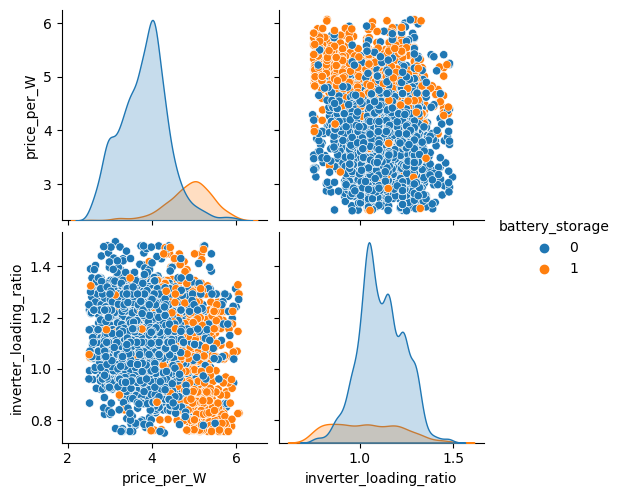

In [4]:
df = df_filt.copy()
df = df[[price_col, 'inverter_loading_ratio', 'battery_storage']]
print("df.shape:", df.shape)
sns.set_style(rc={"axes.grid": False})
sns.pairplot(df, hue='battery_storage')
plt.show()

Ainakin hinnan jakauma näyttää juuri siltä miltä sen oletettiin näyttävän. Akkuasennuksia on yhä huomattavasti vähemmän, mutta ne näyttävät olevan keskimäärin kalliimpia.

Invertterin kuormitussuhteesta huomataan, että akuttomilla järjestelmillä lukema keskittyy hieman kapeammalle alueelle ja selvästi eniten arvoja on välillä 1,0 - 1,2. Akkujärjestelmillä jakauma on melko tasainen välillä 0,8 - 1,2. Ohjelmoijana on mahdotonta arvioida, onko tilanteen taustalla jotain teknistä syytekijää, mutta havainto selittänee osan siitä, miksi piirteen ottaminen mukaan parantaa mallien tarkkuutta.

### Sarakkeiden muokkaus

Tässä vaiheessa muokataan asentajasarake malleille sopivaan muotoon eli numeeriseksi. Tämä voidaan tehdä ainakin kahdella tavalla: korvataan asentajien nimet numerokoodein tai tehdään jokaiselle asentajalle oma sarake, jossa on numero 1 tai 0 riippuen siitä, onko asennus kyseisen asentajan tekemä vai ei. Menettely voi olla tarpeellinen Naive Bayes -luokittelijoille sekä kNN-luokittelijalle, mutta Random Forest ja Decision Tree näyttävät toimivat hyvin yhden sarakkeen numerokoodeillakin.

Vastaavat boolean-sarakkeet tehtiin myös paneeliteknologioille, mutta piirre jätettiin lopulta pois datasta sen osoittauduttua ylimääräiseksi tähän tehtävään.

Tulos tallennetaan jatkoa varten nimellä `df_ML`.

In [5]:
df = df_filt.copy()

# Nämä rivit tekevät asentajille omat sarakkeet
#df.rename(columns={'installer_name': 'i'}, inplace=True)
#df = pd.get_dummies(df, columns=['i'])

# Tällä rivillä vaihtoehtoisesti numerokoodit
df['installer_name'] = df['installer_name'].astype('category').cat.codes


df.drop(['new_construction', 'tracking', 'ground_mounted', 'year', customer_segment], axis=1, inplace=True)
print("df.shape:", df.shape)
display(df.head(5))
df_ML = df

df.shape: (5248, 4)


,price_per_W,inverter_loading_ratio,installer_name,battery_storage
177,3.636388,1.312500,40,0
183,4.262500,1.208333,39,0
317,3.914099,1.188000,39,0
373,4.125616,1.127778,23,0
384,5.617535,0.756303,20,1


## Opetus- ja testiaineisto

Jaetaan edellä valikoitu data opetus- ja testiaineistoon 70-30 jaolla. Malleille menevä data skaalataan välille [0, 1]. Alkuperäiset arvot säilytetään myöhempää käyttöä varten.

In [6]:
df = df_ML.copy()
X = df.drop('battery_storage', axis=1)
y = df['battery_storage']
X_cols = X.columns
random_state = 5451

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

mms = MinMaxScaler().fit(X_train_orig)

X_train = pd.DataFrame(mms.transform(X_train_orig), columns=X_cols)
X_test = pd.DataFrame(mms.transform(X_test_orig), columns=X_cols)

X_train.head(5)


,price_per_W,inverter_loading_ratio,installer_name
0,0.518716,0.401840,0.812500
1,0.105436,0.639644,0.416667
2,0.700854,0.498738,0.333333
3,0.161661,0.854196,0.145833
4,0.536769,0.394064,0.604167


## Luokittelijat

Seuraavaksi valitaan luokittelijat ja määritetään niille muutama parametri käyttäen muuten niiden oletusarvoja. Yhtenä jatkokehityskohteena tässä mallinnuksessa olisi parametrien säätö parempiin arvoihin, jolloin mallien tarkkuus saattaisi olla jonkin verran parempi.

In [7]:
names = [
  'Gaussian NB',
  'Complement NB',
  'k Nearest Neighbors',
  'Decision Tree',
  'Random Forest'
]

classifiers = [
  GaussianNB(),
  ComplementNB(),
  KNeighborsClassifier(1),
  DecisionTreeClassifier(random_state=random_state),
  RandomForestClassifier(random_state=random_state)
]


## Mallien ajo

Valituilla malleilla on hyvin yhtenevät funktiot, mikä helpottaa mallien ajamista silmukassa, joten niin on myös tehty. Jokaiselle mallille on laskettu tarkkuus kahdella tavalla, koska epätasapaino akuttomien ja akullisten järjestelmien määrissä on suuri. Jälkimmäinen tarkkuus ottaa paremmin huomioon kuinka monta akkujärjestelmää tunnistetaan tai jää tunnistamatta.

Mallien ajon jälkeen hinnan jakaumista piirretään kuvaajat kullekin mallille ja alkuperäiselle testidatalle. Tätä varten silmukassa kootaan DataFrame `df_d` apumuuttujan `df_temp` avulla. Lisäksi päätöspuita käyttävien mallien tuottamat tiedot piirteiden tärkeydestä kootaan `df_i`:hin.

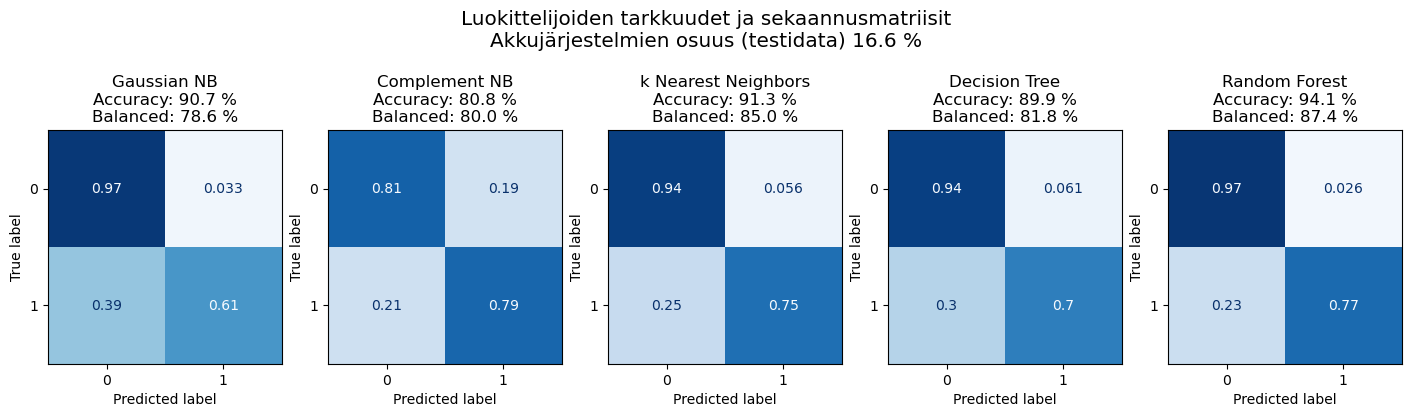

,price_per_W,inverter_loading_ratio,installer_name
Decision Tree,0.685774,0.210096,0.104130
Random Forest,0.602849,0.296340,0.100811


In [8]:
model = 'model'              # Nimi model-sarakkeelle
orig = 'Original test data'  # Testiaineiston tunnistusta varten
ind = X_test_orig.index      # Kopioidaan indeksi liitettäväksi ennusteisiin

df_d = pd.concat([X_test_orig, y_test], axis=1)
akku_osuus_test = round(df_d['battery_storage'].mean() * 100, 1)
df_d[model] = orig
df_i = pd.DataFrame()
acc_range = {"vmin": 0, "vmax": 1}  # Teoreettiset min ja max arvot sekaannusmatriiseissa


fig, axs = plt.subplots(1, len(classifiers), layout="constrained", figsize=(14, 4))

for name, clf, i in zip(names, classifiers, range(len(classifiers))):
  y_pred = clf.fit(X_train, y_train).predict(X_test)

  acs = accuracy_score(y_test, y_pred)
  bacs = balanced_accuracy_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')

  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot(ax=axs[i], cmap=plt.cm.Blues, colorbar=False, im_kw=acc_range)
  axs[i].set_title(f'{name}\nAccuracy: {round(acs * 100, 1)} %\nBalanced: {round(bacs * 100, 1)} %')  #\nMean acc: {round((acs + bacs) * 50, 1)} %')

  df_temp = pd.concat([X_test_orig, pd.Series(y_pred, index=ind, name='battery_storage')], axis=1)
  df_temp[model] = name
  df_d = pd.concat([df_d, df_temp])

  if (name == 'Random Forest') or (name == 'Decision Tree'):
    importances = clf.feature_importances_
    for j in range(len(importances)):
      df_i.loc[name, X_cols[j]] = importances[j]


title = f'''Luokittelijoiden tarkkuudet ja sekaannusmatriisit
Akkujärjestelmien osuus (testidata) {akku_osuus_test} %
'''

mpl.rcParams['figure.titlesize'] = 'x-large'
fig.suptitle(title)
plt.show()
display(df_i)

### Alustava tulkinta tarkkuudesta

Ilman parempien hyper-parametrien hakemista tarkimmaksi luokittelijaksi osoittautuu Random Forest. Sen tarkkuuksien arvot ovat korkeimmat. Complement NB luokittelee kyllä eniten akkujärjestelmiä oikein, mutta samalla akuttomia luokitellaan verraten paljon virheellisesti, jolloin luokittelijan toimivuus on kokonaisuudessaan joukon heikommasta päästä.

Mallien kyky luokitella akkujärjestelmiä oikein ei yllä hyvälle tasolle, mutta data huomioiden tulos oli ehkä odotettukin.

Päätöspuuta käyttävien mallien palaute piirteiden suhteellisesta tärkeydestä ei välttämättä kerro mitään muiden mallien toiminnasta, mutta tärkeydet ainakin hinnan osalta tuntuvat loogisilta. Tuloksen selkeys kertoo vähän myös siitä, että data on onnistuttu suodattamaan malleja varten. Toisenlaisella suodatuksella asentajan vaikutus saattaisi olla korkeampi, esimerkiksi jos mukana olisi asentajia, jotka eivät olisi tehneet akkujärjestelmien asennuksia. Omassa analyysissä jää arvoitukseksi, onko Random Forest tarkempi juuri korkeamman invertterin kuormitussuhteen tärkeyden vuoksi.

### Hintajakaumat

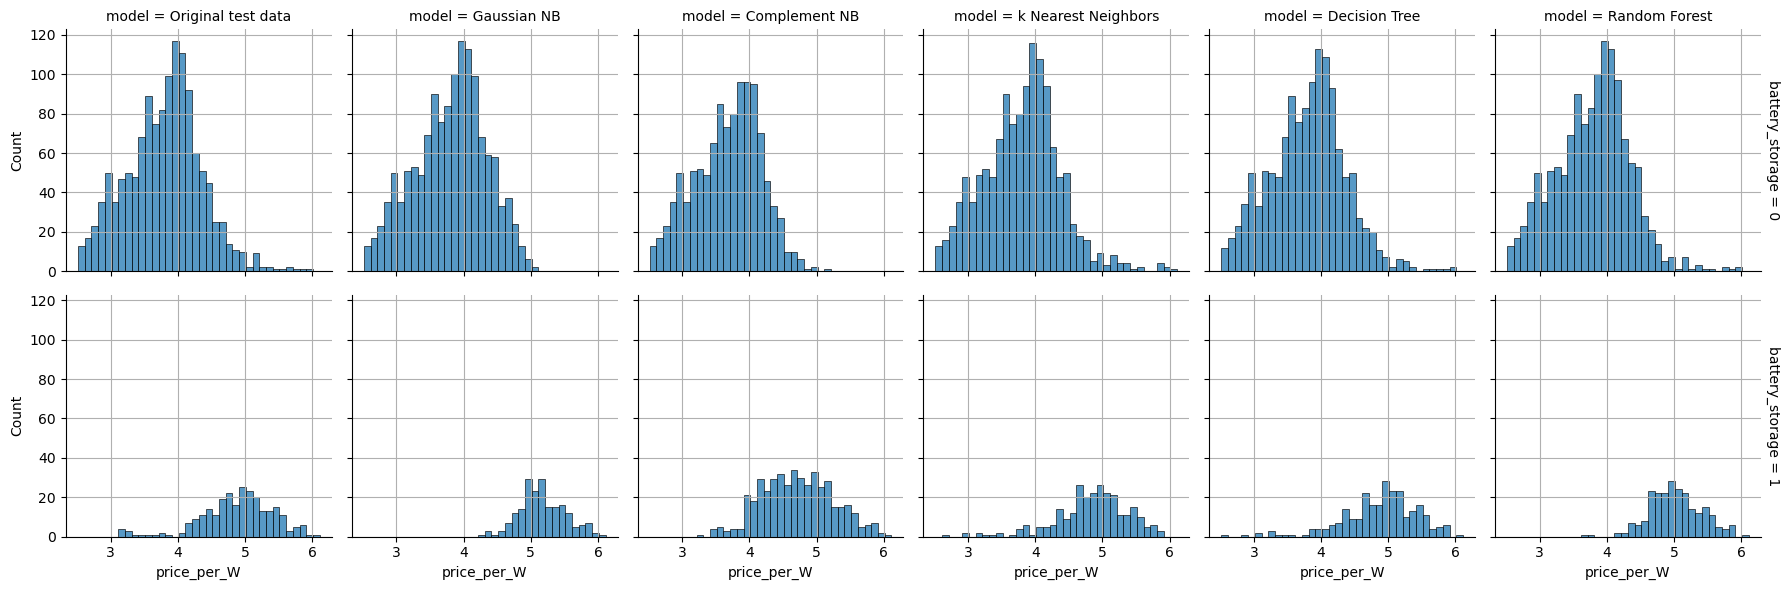

In [9]:
sns.set_style(rc={"axes.grid": True})
sns.displot(
  df_d, x=price_col, col=model, row='battery_storage',
  binwidth=.1, height=3, facet_kws=dict(margin_titles=True)
)
plt.show()


### Hintajakaumien tulkintaa

Kaikki mallit toimivat vähintään kohtalaisesti näiden tärkeiksi katsottujen hintajakaumien perusteella. Hintaperuste näkyy erityisen selvästi Naive Bayes -luokittelijoilla, sillä ne luokittelevat yli 5 $/W maksavat järjestelmät lähes poikkeuksetta akullisiksi. Lisäksi Gaussian-luokittelijalla on melko heikko kyky tunnistaa halvempia akkujärjestelmiä. Toisaalta eniten oikeita akkuja tunnistanut Complement-luokittelija näyttää saavuttaneen tuloksensa luokittelemalla suhteettoman paljon järjestelmiä akullisiksi huonontaen kokonaistarkkuutta.

Muiden mallien kohdalla tarkempaa analyysiä on vaikea tehdä näiden kuvaajien perusteella, sillä tulos on kohtalaisen tarkka.

Näitä kuvaajia tulkitessa on toki hyvä muistaa, että pelkkä palkkien korkeus ei kerro koko totuutta mallien hyvyydestä, jos esimerkiksi jossain hintahaarukassa luokittelut ovat määrällisesti täsmällisiä, mutta menevät ikään kuin päittäin väärin päin.

## Tiheyskäyrät ja hajontakaaviot

Analyysin jatkamiseksi piirretään lisää kuvaajia. Seuraavissa kuvaajissa on mukana myös hieman yllättäen vaikuttavaksi piirteeksi paljastunut invertterin kuormitussuhde (inverter loading ratio). Hinta pysyy edelleen toisena kuvaajien piirteenä.

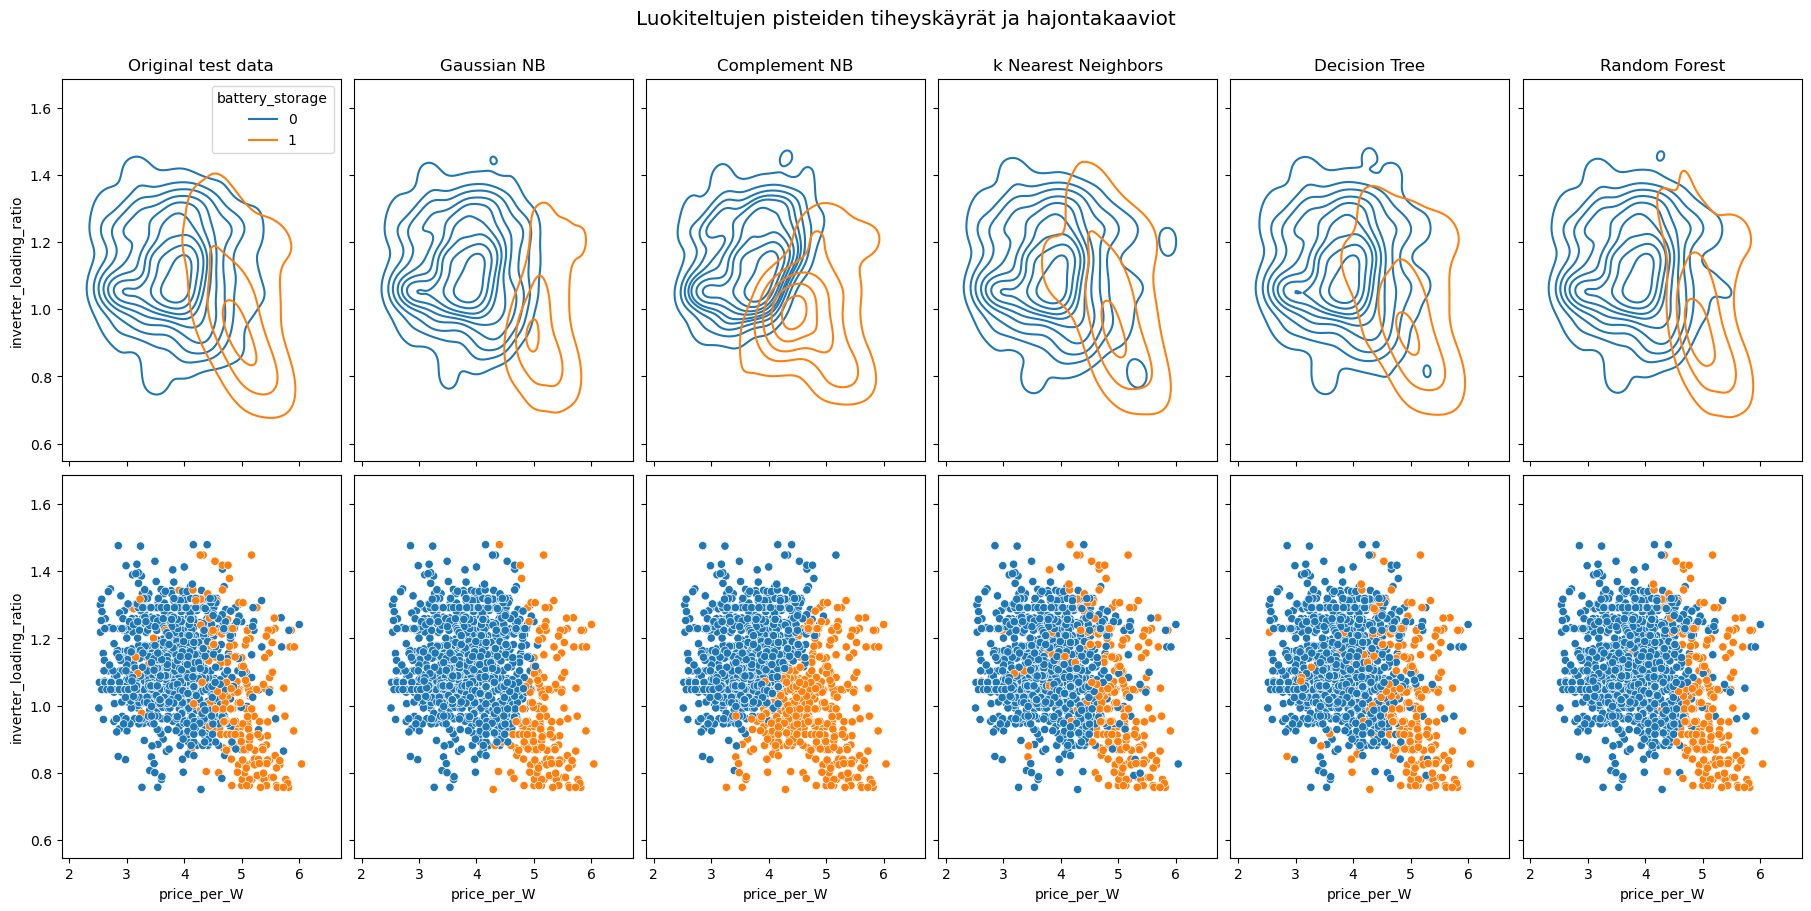

In [10]:
models = names[:]
models.insert(0, orig)

sns.set_style(rc={"axes.grid": False})
fig, axs = plt.subplots(2, len(models), sharex=True, sharey=True, layout="constrained", figsize=(18, 9))
legend_display = True

for name, i in zip(models, range(len(models))):
  df = df_d.copy()
  df = df[(df[model] == name)]
  axs[0, i].set_title(name)
  sns.kdeplot(data=df, x=price_col, y="inverter_loading_ratio", hue="battery_storage", ax=axs[0, i], legend=legend_display)
  legend_display = False
  sns.scatterplot(data=df, x=price_col, y="inverter_loading_ratio", hue="battery_storage", ax=axs[1, i], legend=legend_display)


title = f'''Luokiteltujen pisteiden tiheyskäyrät ja hajontakaaviot
'''

fig.suptitle(title)
plt.show()

### Gaussian NB ja Complement NB

Valittujen Naive Bayes -luokittelijoiden luonne näkyy yllä olevissa kuvaajissa jo selkeästi, vaikka asentajan vaikutusta niissä ei näy. Pistejoukko jakautuu melko puhtaasti kahteen puoleen. Puolien rajat ovat jopa tunnistettavissa, jos kuvia verrataan muiden mallien kuviin. Mallit toimivat siis huonosti, jos datassa eri luokkiin kuuluvat pisteet levittäytyvät samalle alueelle ja tiheyskäyrät menevät oikeassa datassa selvästi päällekkäin.

Toisaalta mallien kehno tarkkuus voi johtua mallien tavasta käsitellä kuvaajien ulkopuolelle jätetty piirre eli asentaja. Asentaja on kuitenkin lopulta kategorinen muuttuja eikä sen numeerinen arvo kerro mistään todellisesta järjestelmän ominaisuudesta. Edellä laskettujen tarkkuuksien mukaan muut mallit selviävät tästä huolimatta luokittelusta edes vähän paremmin.

Jos asentaja haluttaisiin huomioida näillä malleilla mahdollisimman tarkasti, mallit tulisi ajaa jokaiselle asentajalle erikseen, jolloin koko piirre voitaisiin käytännössä jättää pois opetus- ja testiaineistosta.

### kNN, Decision Tree ja Random Forest

Yhtenä huomion arvoisena asiana kuvaajista nousee esiin tarkimpien mallien kohdalla sisimpien tiheyskäyrien piirtyminen hyvin samankaltaisina kuin oikeassa testiaineistossa. Ulommat käyrät vaihtelevat enemmän, mikä voisi viitata siihen, että "laidoilla" ja sitä myöten väljemmällä alueella olevien pisteiden luokittelu on malleille vaikeaa. Toisaalta tiheyskäyrien piirtäminen jo itsessään karsii poikkeavien arvojen näkyvyyttä, jolloin asiaan on hankalampaa ottaa kantaa.

Mielenkiintoisena yksityiskohtana mainittakoon vielä lähimpänä kuvion keskikohtaa oleva akkujärjestelmien uloin tiheyskäyrä. Vaikka se oikeassa datassa kulkee melko suoraan, ja vähän akuttomien sisimmän tiheyskäyrän päältä, niin kNN, Decision Tree kuin Random Forest eivät onnistu piirtämään (eli luokittelemaan) kyseistä kohtaa tarkasti. Tämä voi johtua siitä, että kyseisellä alueella invertterin kuormitussuhteen lukemasta on erityisen vähän hyötyä luokittelussa, koska niin monta järjestelmää on lähellä samoja arvoja. Osittain samasta syystä voi johtua akuttomien uloimman käyrän epätarkkuus invertterin kuormitussuhteen tyypillisillä arvoilla (1,0 - 1,2), vaikka käyrä on muutenkin melko epätarkka, kun hinta on yli 4 $/W.